In [1]:
%%HTML
<style>
p {
    color: #343a40;
}

h1 a.anchor-link {
    color: #F7ECCB;
}

h1 {
    background-color: #343a40;
    width: fit-content;
    padding: 15px;
    color: white;
    text-align: center;
    width: 100%;
}

.intro {
    width: 60%;
    margin: auto;
    text-align: justify !important;
    font-family: Georgia;
}

.output_png {
    display: flex;
    align-items: center;
    justify-content: center;
}

.hide_btn {
    background-color: #343a40;
    padding: 15px;
    color: white;
    border-radius: 30px;
    border: none;
}
</style>

In [2]:
%%HTML
<script>
    code_show=true;
    function code_toggle() {
         if (code_show){
             $('div.input').hide();
         } else {
             $('div.input').show();
         }
         code_show = !code_show
    }
    $( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()">
    <input class='hide_btn' type="submit"
    value="Toggle code">
</form>

In [3]:
import os
os.environ['SKIMAGE_DATADIR'] = '/tmp/.skimage_cache'

In [6]:
from skimage.io import imread, imshow
from skimage.transform import downscale_local_mean
from skimage.color import rgb2gray, rgb2hsv, gray2rgb
from skimage import img_as_ubyte, img_as_float
from skimage.exposure import histogram, cumulative_distribution

In [194]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.stats import norm

# Chapter 2: The way I enhanced him

<p class='intro'><br>Dear diary,<br>
Dear Diary,
After days of searching, I finally found him! Okay, I didn’t find him in real life, but at least I found his social media! That’s one step closer. He even posted a story of him playing his guitar! It’s a little bit dark though, and it seems he used a filter making it hard to see him. Let’s see if we can do something about that with the help of some image processing.
</p>
<p class='intro'><i>I need to see him play.</i></p>

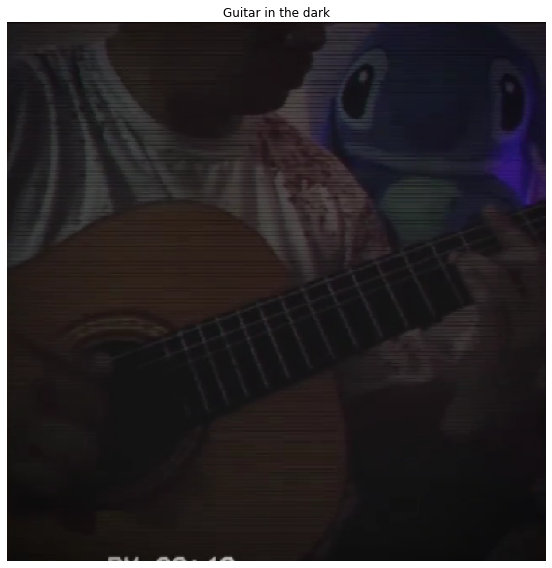

In [201]:
ch2 = imread('images/ch2.png')
plt.figure(figsize=(20, 8))
plt.axis('off')
plt.title('Guitar in the dark')
plt.tight_layout()
plt.imshow(ch2);

First, I need to fix this lighting. I mean, it’s just too dark! I can’t even see where he is. We can use histogram manipulation to more evenly distribute the dark values and allow for “better lighting”. The better to see you with, my dear.

In [20]:
print("Unique R values:", len(np.unique(ch2[:,:,0])))
print("Unique G values:", len(np.unique(ch2[:,:,1])))
print("Unique B values:", len(np.unique(ch2[:,:,2])))
print("Unique RGB values:", len(np.unique(ch2)))

Unique R values: 153
Unique G values: 148
Unique B values: 169
Unique RGB values: 195


But there’s a problem! Histogram manipulation needs us to find the cumulative distribution of the image values. With missing values in the image, our interpolation won’t work! We need the 255 unique RGB values. So let’s do a quick fix for that. We can't leave this cutie in the dark.

In [21]:
# fill in missing values for the histogram
missing_vals = []

missing_r = list(set(np.arange(255)) - set(np.unique(ch2[:,:,0])))
missing_g = list(set(np.arange(255)) - set(np.unique(ch2[:,:,1])))
missing_b = list(set(np.arange(255)) - set(np.unique(ch2[:,:,2])))

for i, b in enumerate(missing_b):
    r = 0
    g = 0
    if i < len(missing_r):
        r = missing_r[i]
    if i < len(missing_g):
        g = missing_g[i]
    missing_vals.append([r, g, b])
    
ch2[-1,:len(missing_vals)] = missing_vals

In [22]:
print("Unique R values:", len(np.unique(ch2[:,:,0])))
print("Unique G values:", len(np.unique(ch2[:,:,1])))
print("Unique B values:", len(np.unique(ch2[:,:,2])))
print("Unique RGB values:", len(np.unique(ch2)))

Unique R values: 234
Unique G values: 229
Unique B values: 253
Unique RGB values: 255


Adding the missing values to the last row of the image shouldn’t affect the distribution that much. . . et voila! We now have the unique 255 RGB values, and our histogram manipulation should work now. Let's check out the effects of different sets of distribution parameters.

In [28]:
def manipulate_histogram(image, target_bins, target_freq):
    
    image_intensity = img_as_ubyte(image)
    intensity_data = {}
    for i, c in enumerate('rgb'):
        intensity_data[c] = cumulative_distribution(image_intensity[:,:,i],
                                                    nbins=256)
        
    new_vals = {}
    for key in intensity_data.keys():
        freq = intensity_data[key][0]
        new_vals[key] = np.interp(freq, target_freq, target_bins)
        
    image_manip = image.copy()
    image_manip[:,:,0] = img_as_ubyte(new_vals['r'][image_intensity[:,:,0]]
                                      .astype('uint8'))
    image_manip[:,:,1] = img_as_ubyte(new_vals['g'][image_intensity[:,:,1]]
                                      .astype('uint8'))
    image_manip[:,:,2] = img_as_ubyte(new_vals['b'][image_intensity[:,:,2]]
                                      .astype('uint8'))
    
#     plt.axis('off')
#     plt.imshow(image_manip);
    
    return image_manip

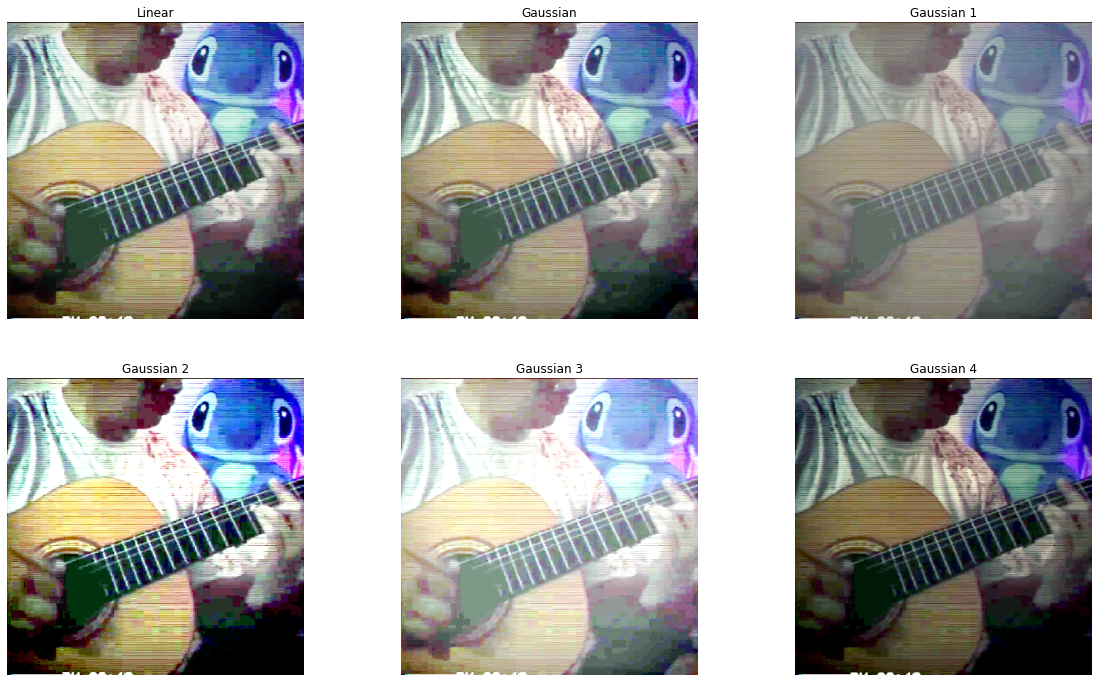

In [33]:
# linear
linear_bins = np.arange(255)
linear_freq = np.linspace(0, 1, len(linear_bins))

linear = manipulate_histogram(ch2, linear_bins, linear_freq)

gaussian = norm(128, 64)

gs_bins = np.arange(0,256)
gs_freq = gaussian.cdf(np.arange(0,256))

gs = manipulate_histogram(ch2, gs_bins, gs_freq)

# same mean, less sdev
# colors are duller since color range is more limited
# less contrast
other1 = norm(128, 32)

other1_bins = np.arange(0,256)
other1_freq = other1.cdf(np.arange(0,256))

other1 = manipulate_histogram(ch2, other1_bins, other1_freq)

# same mean, more sdev
# colors are more vibrant since there is a higner range for colors
# more contrast too
other2 = norm(128, 128)

other2_bins = np.arange(0,256)
other2_freq = other2.cdf(np.arange(0,256))

other2 = manipulate_histogram(ch2, other2_bins, other2_freq)

# higher mean, same sdev
# colors are distributed closer to 255 (white), so image seems whiter
other3 = norm(192, 64)

other3_bins = np.arange(0,256)
other3_freq = other3.cdf(np.arange(0,256))

other3 = manipulate_histogram(ch2, other3_bins, other3_freq)

# lower mean, same sdev
# colors are distributed closer to 0, so image is darker
other4 = norm(64, 64)

other4_bins = np.arange(0,256)
other4_freq = other4.cdf(np.arange(0,256))

other4 = manipulate_histogram(ch2, other4_bins, other4_freq)

imgs = [linear, gs, other1, other2, other3, other4]
titles = ['Linear', 'Gaussian', 'Gaussian 1', 'Gaussian 2',
          'Gaussian 3', 'Gaussian 4']

fig, axs = plt.subplots(2, 3, figsize=(20, 12))

for i, ax in enumerate(axs.ravel()):
    ax.imshow(imgs[i])
    ax.axis('off')
    ax.set_title(titles[i])

You can see a smattering of red on his shoulders, likely an artifact of the image processing we just did. Or maybe, he’s making me see red, for how full he makes my heart feel, *sigh*. I think I’m going to choose the image that was edited with the linear distribution as my basis to remove the noise. I think it’s what looks best out of all the six.

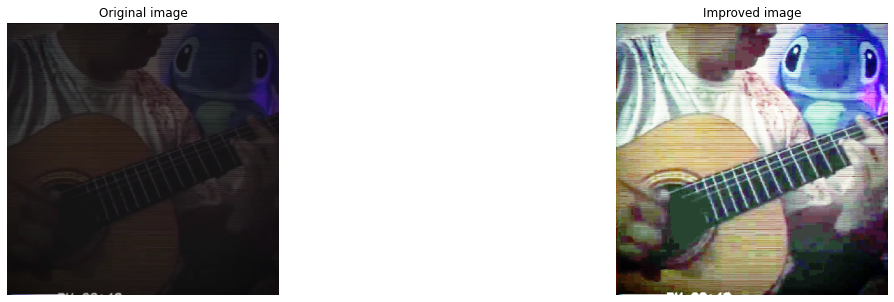

In [34]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20, 5))
ax1.imshow(ch2)
ax1.axis('off')
ax1.set_title('Original image');
ax2.imshow(linear)
ax2.axis('off')
ax2.set_title('Improved image');

Much, much better. I can see his features now. That's a pretty cute Stitch plush as well, maybe I'll get to play with it one day. Buuuut, the image is still a little noisy. To remove the horizontal lines along the image, maybe we can use the Fourier transform space.

Fourier transform works by applying a transformation on an image, like below. The Fourier transform of the grid is a dot in the middle. If you covered up that dot in the middle and then re-transformed the image, you'd lose some of the image information. This can be one way to remove noise.

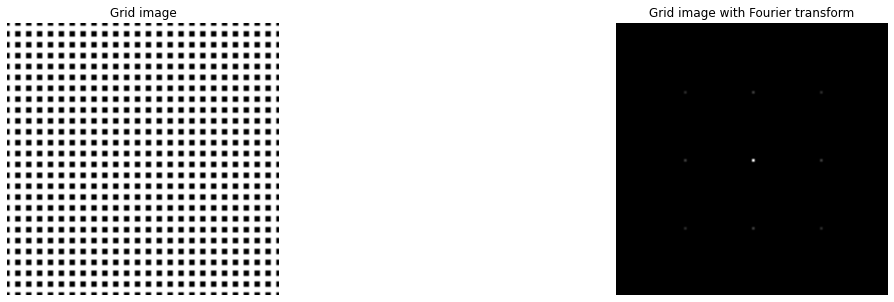

In [36]:
image_grid = np.zeros((100, 100))
image_grid[:,1::4] = 255
image_grid[:,2::4] = 255
image_grid[1::4,:] = 255
image_grid[2::4,:] = 255

image_grid_fft = np.fft.fftshift(np.fft.fft2(image_grid))

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20, 5))

ax1.imshow(image_grid, cmap='gray')
ax1.axis('off')
ax1.set_title('Grid image');
ax2.imshow(abs(image_grid_fft), cmap='gray')
ax2.axis('off')
ax2.set_title('Grid image with Fourier transform');

Let's apply the Fourier transform, and mask the resulting image to try and get rid of the noise. I used the transformation from the red channel.

In [96]:
guitar_R = linear[:, :, 0]
guitar_G = linear[:, :, 1]
guitar_B = linear[:, :, 2]

In [140]:
def get_ft(image, name='img'):
    image_fft = np.fft.fftshift(np.fft.fft2(image))

#     fig, ax = plt.subplots(1, 3, gridspec_kw=dict(width_ratios=[16,16,1]),figsize=(16,8))
#     ax[0].imshow(image, cmap='gray')
#     ax[0].set_title(name + ' Channel')
#     ax[1].imshow(np.log(abs(image_fft)), cmap='gray')
#     ax[1].set_title(name + ' Fourier Transform')
#     fig.colorbar(img, cax=ax[2]);

    return image_fft

In [141]:
R_fft, G_fft, B_fft = get_ft(guitar_R, 'Red'), get_ft(guitar_G, 'Green'), get_ft(guitar_B, 'Blue')

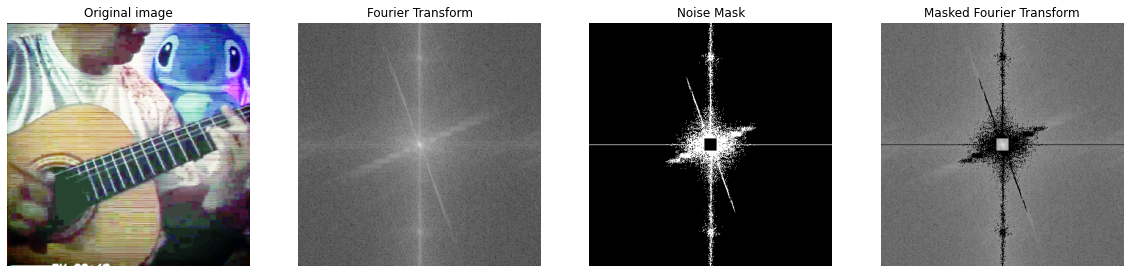

In [161]:
guitar_mask = abs(R_fft/R_fft.max()) > 0.001
guitar_mask[200] = 1
guitar_mask[:,200] = 1

def ignore_middle(image, size, cross=False):
    mid_x = image.shape[0]//2
    mid_y = image.shape[1]//2
    
    if cross:
        image[(mid_x-(size*3)):(mid_x+(size*3)), (mid_y-size):(mid_y+size)] = 0
        image[(mid_x-size):(mid_x+size), (mid_y-(size*3)):(mid_y+(size*3))] = 0
    else:
        image[(mid_x-size):(mid_x+size), (mid_y-size):(mid_y+size)] = 0

    return image

guitar_mask = ignore_middle(guitar_mask, 10) # mask middle

def apply_mask(fft, mask, return_mask=False):
    fft2 = fft.copy()
    fft2[mask] = 1
#     fig, ax = plt.subplots()
#     ax.imshow(np.log(abs(fft2)), cmap='gray')
    
    if return_mask:
        return np.log(abs(fft2))

    return abs(np.fft.ifft2(fft2))

new_R, new_G, new_B = apply_mask(R_fft, guitar_mask), apply_mask(G_fft, guitar_mask), apply_mask(B_fft, guitar_mask)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,figsize=(20, 5))

ax1.imshow(linear, cmap='gray')
ax1.axis('off')
ax1.set_title('Original image');
ax2.imshow(np.log(abs(R_fft)), cmap='gray')
ax2.axis('off')
ax2.set_title('Fourier Transform');
ax3.imshow(guitar_mask*1, cmap='gray')
ax3.axis('off')
ax3.set_title('Noise Mask');
ax4.imshow(apply_mask(R_fft, guitar_mask, True), cmap='gray')
ax4.axis('off')
ax4.set_title('Masked Fourier Transform');

Now, let's recreate the colored image after applying those transforms and masking operations. . . and. . . wow. That totally did not work. What a fail. Still, despite being unable to remove the noise (or perhaps removing too much noise?), he still looks cool playing the guitar. The image is definitely more of a blur now, but at least the lines are gone.

In [162]:
new_guitar = ch2.copy()
new_guitar[:, :, 0] = new_R
new_guitar[:, :, 1] = new_G
new_guitar[:, :, 2] = new_B

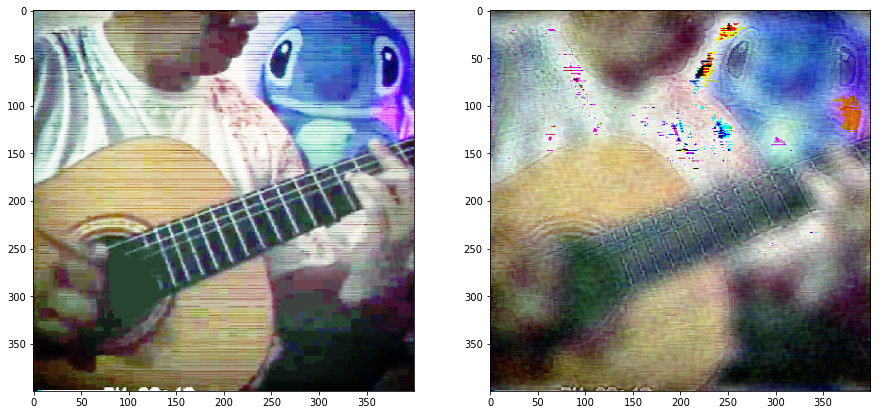

In [163]:
fig, ax = plt.subplots(1,2, figsize=(15,10))
ax[0].imshow(linear)
ax[1].imshow(new_guitar);

Let me try this Fourier transform on this astronaut, to make me feel better about that fail. He seems to like space, especially Star Wars.

/tmp/ipykernel_59349/3398236019.py:1: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  moon = rgb2gray(imread('images/moon_image.png'))


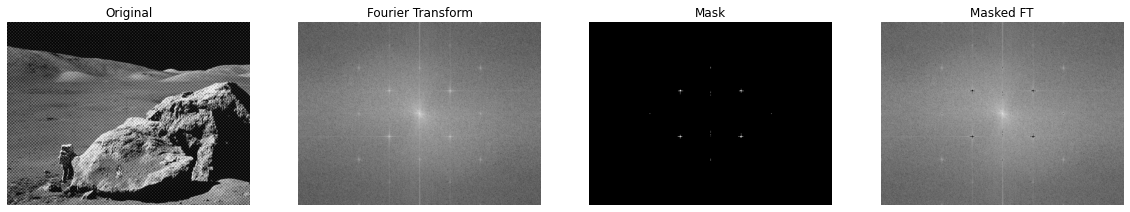

In [175]:
moon = rgb2gray(imread('images/moon_image.png'))
moon_fft = np.fft.fftshift(np.fft.fft2(moon))

moon_mask = abs(moon_fft/moon_fft.max()) > 0.005
moon_mask[192:282, 270:360] = 0

moon_fft2 = moon_fft.copy()
moon_fft2[moon_mask] = 1

images = [moon, np.log(abs(moon_fft)), moon_mask*1,
          np.log(abs(moon_fft2))]
titles = ['Original', 'Fourier Transform', 'Mask', 'Masked FT']

fig, axs = plt.subplots(1, 4, figsize=(20,10))

for i, ax in enumerate(axs.ravel()):
    ax.imshow(images[i], cmap='gray')
    ax.axis('off')
    ax.set_title(titles[i]);

Well, that's a bit better. I wasn't able to completely remove the noise, but I think I got most of it.

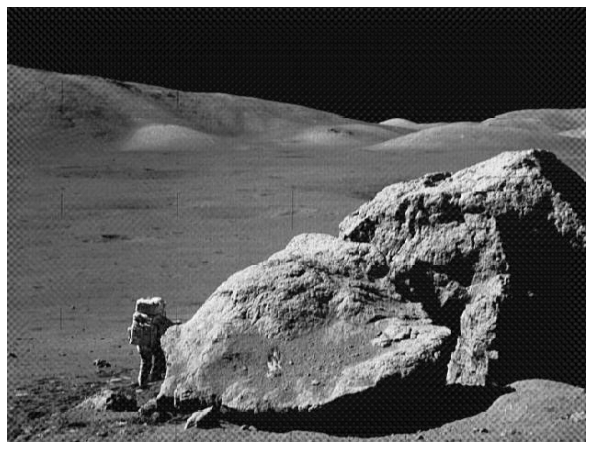

In [176]:
plt.figure(figsize=(20, 8))
plt.axis('off')
plt.imshow(abs(np.fft.ifft2(moon_fft2)), cmap='gray');

Another treat for me, I found this image of a bunch of cups off of his social media again. Let me try to white-balance it using the White Patch, Gray World, and Ground Truth algorithms.

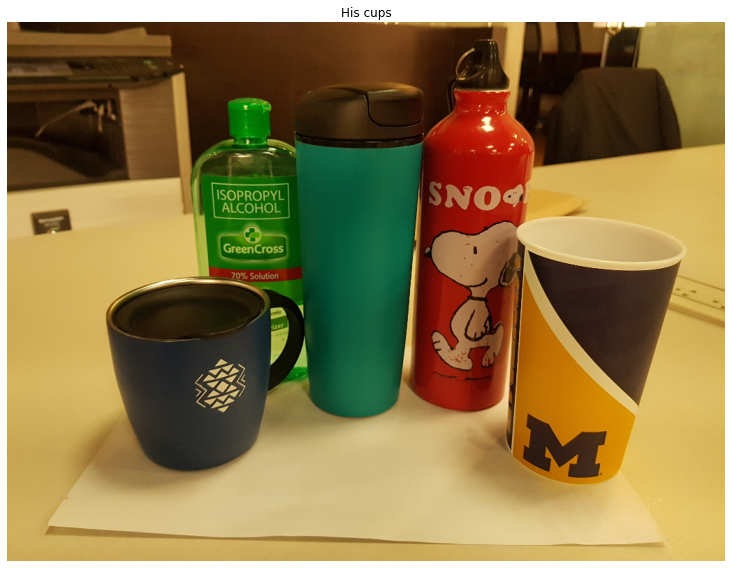

In [180]:
cups = imread('images/wb_sepia2.png')
plt.figure(figsize=(20, 8))
plt.axis('off')
plt.title('His cups')
plt.tight_layout()
plt.imshow(cups);

In [197]:
def white_patch(image, percentile=100):
    """White balance image using White patch algorithm
    
    Parameters
    ----------
    image : numpy array
        Image to white balance
    percentile : integer, optional
        Percentile value to consider as channel maximum
        
    Returns
    -------
    image_wb : numpy array
        White-balanced image
    """
    image_wp = img_as_ubyte((image*1.0 / np.percentile(image,
                                                       percentile,
                                                       axis=(0, 1)))
                            .clip(0, 1))

    fig, ax = plt.subplots(1,2, figsize=(15,10))
    ax[0].imshow(image)
    ax[0].axis('off')
    ax[0].set_title('Original image')
    ax[1].imshow(image_wp)
    ax[1].set_title(str(percentile) + 'th percentile')
    ax[1].axis('off');
    
    return image_wp
    
def gray_world(image):
    """White balance image using Gray-world algorithm

    Parameters
    ----------
    image : numpy array
        Image to white balance

    Returns
    -------
    image_wb : numpy array
        White-balanced image
    """
    return ((image * (image.mean() / image.mean(axis=(0, 1))))
            .clip(0, 255).astype(int))
    
def ground_truth(image, patch_loc, patch_size=50):
    """White balance image using Ground-truth algorithm

    Parameters
    ----------
    image : numpy array
        Image to white balance

    Returns
    -------
    image_wb : numpy array
        White-balanced image
    """
    x, y = patch_loc
    patch = image[x:x+patch_size, y:y+patch_size]
    
    gt_max = (image*1.0 / patch.max(axis=(0, 1))).clip(0, 1)
    
    gt_mean = ((image * (patch.mean() / image.mean(axis=(0, 1))))
               .clip(0, 255).astype(int))
    
    fig, axs = plt.subplots(1,3, figsize=(15,10))

    axs[0].imshow(image)
    axs[0].axis('off')
    axs[0].set_title('Original')
    axs[0].add_patch(Rectangle(patch_loc, patch_size, patch_size,
                               edgecolor='r', facecolor='none'));
    
    axs[1].set_title('Max')
    axs[1].axis('off')
    axs[1].imshow(gt_max)
    
    axs[2].set_title('Mean')
    axs[2].axis('off')
    axs[2].imshow(gt_mean)

This is what white balancing looks like using the White Patch algorithm. We take the 90th percentile, which seems to provide good color correction for the image. White - like his shirt when he was playing that guitar.

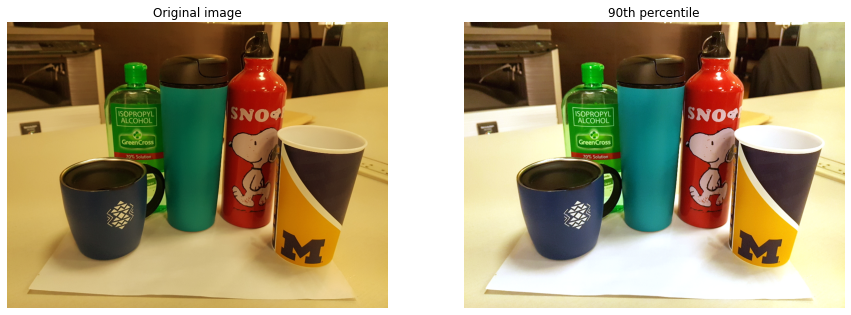

In [198]:
wp = white_patch(cups, percentile=90)

This image was generated using the Gray World algorithm, which assumes that the world is, on average, gray. Like my world is, without him.

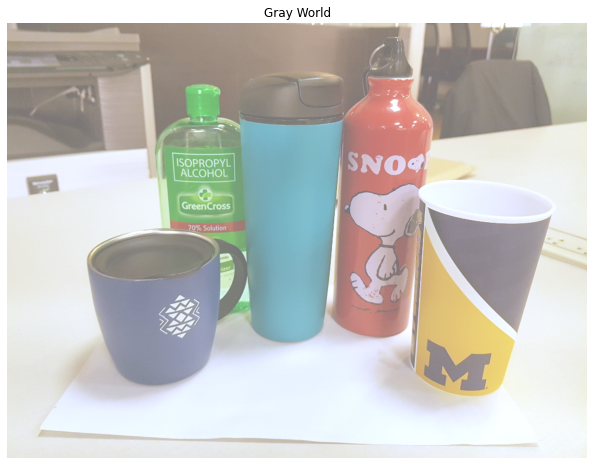

In [199]:
plt.figure(figsize=(20, 8))
plt.axis('off')
plt.title('Gray World')
plt.imshow(gray_world(cups));

And this final image uses the Ground Truth algorithm, which uses a patch from the image as a 'white' ground truth. Look at him, so nice to provide the bond paper as the ground truth. Well, I like him so dang much, and *that's* my ground truth.

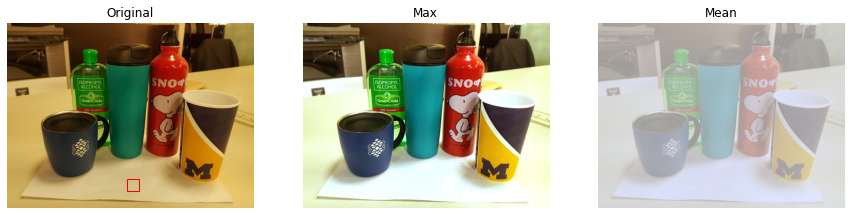

In [200]:
ground_truth(cups, (500,650), patch_size=50)

Let's try those algorithms on his guitar-playing image.

Gray World Algorithm


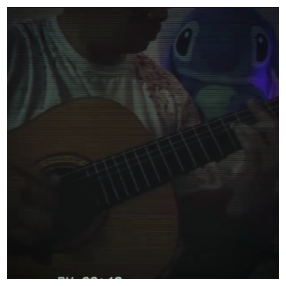

In [209]:
print('Gray World Algorithm')
plt.figure(figsize=(20, 5))
plt.axis('off')
plt.imshow(gray_world(ch2));

Ground Truth Algorithm


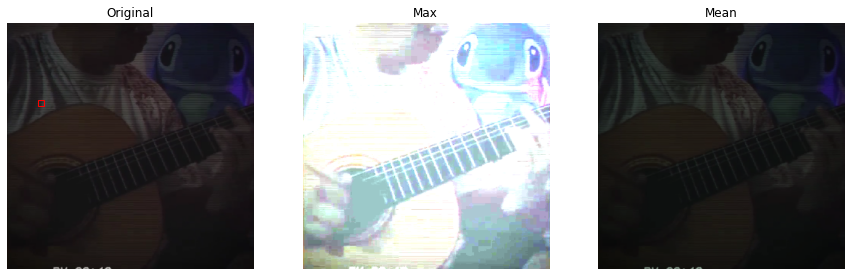

In [213]:
print('Ground Truth Algorithm')
ground_truth(ch2, (50,125), patch_size=10)

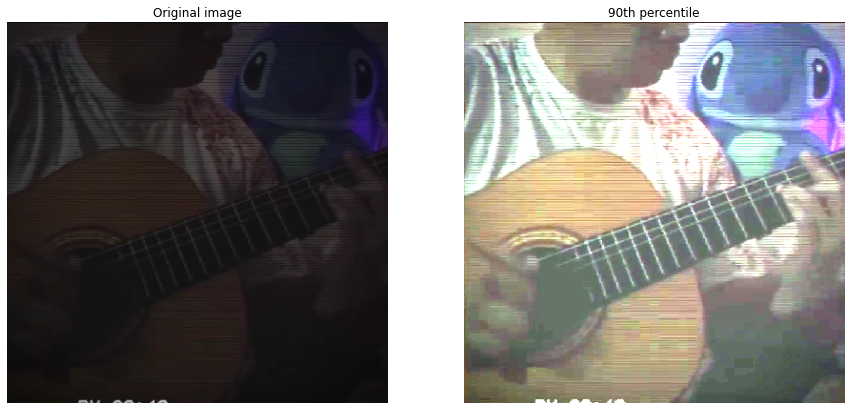

In [208]:
print('White Patch Algorithm')
wp = white_patch(ch2, percentile=90)

<p class='intro'>What a talent. He plays the guitar so well. I just know he’s the one for me. And me, the one for him. I mean, look at how I was able to bring out the best in him! He doesn’t know it yet, but he will. I’ll be watching him from the shadows, his guardian angel in the dark.</p>
<p class='intro'><i>I’m hoping he sees me soon. . . xoxo</i></p>